In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import optimizers, callbacks, metrics, losses
import keras as k
import numpy as np
import matplotlib.pyplot as plt
from models import *
import tensorflow as tf

from tensorflow.keras.utils import plot_model

In [16]:
df = pd.read_csv('dataset/features_3_sec.csv')
df.head(3)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues


In [3]:
df.drop(columns=['filename', 'length'], inplace=True)

In [4]:
num_classes = len(df['label'].unique())

In [5]:
encoder = LabelEncoder()
X = df.drop(columns='label')
y = encoder.fit_transform(df['label'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.66, random_state=42, stratify=y_test)

In [7]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [8]:
input_shape = X_train_scaled.shape[1:]

In [9]:
baseline = create_baseline(input_shape, num_classes)
regularized = create_regularized_model(input_shape, num_classes)
normalized = create_normalized_model(input_shape, num_classes)

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

# hyper parameters
callback = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
]
loss = losses.SparseCategoricalCrossentropy()
batch_size = 64
lr = 0.001
metric = [
    metrics.SparseCategoricalAccuracy()
]

baseline.compile(
    loss=loss,
    optimizer=optimizers.Adam(learning_rate=lr),
    metrics=metric
)
regularized.compile(
    loss=loss,
    optimizer=optimizers.Adam(learning_rate=lr),
    metrics=metric
)
normalized.compile(
    loss=loss,
    optimizer=optimizers.Adam(learning_rate=lr),
    metrics=metric
)

In [13]:
brew install graphviz

SyntaxError: invalid syntax (797003321.py, line 1)

# Baseline

In [ ]:
baseline_history = baseline.fit(
    X_train_scaled, 
    y_train, 
    epochs=100,
    validation_data = (X_val_scaled, y_val),
    callbacks=callback
)

Epoch 1/100
219/219 [==============================] - 3s 11ms/step - loss: 1.2352 - sparse_categorical_accuracy: 0.5870 - val_loss: 0.9122 - val_sparse_categorical_accuracy: 0.6938 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 2s 10ms/step - loss: 0.7288 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.7000 - val_sparse_categorical_accuracy: 0.7576 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 2s 10ms/step - loss: 0.5133 - sparse_categorical_accuracy: 0.8194 - val_loss: 0.5945 - val_sparse_categorical_accuracy: 0.7890 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 2s 11ms/step - loss: 0.3837 - sparse_categorical_accuracy: 0.8689 - val_loss: 0.5927 - val_sparse_categorical_accuracy: 0.8037 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 2s 10ms/step - loss: 0.2942 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.5973 - val_sparse_categorical_accuracy: 0.8077 - lr: 0.0010
Epoch 6/100
219/219 [====

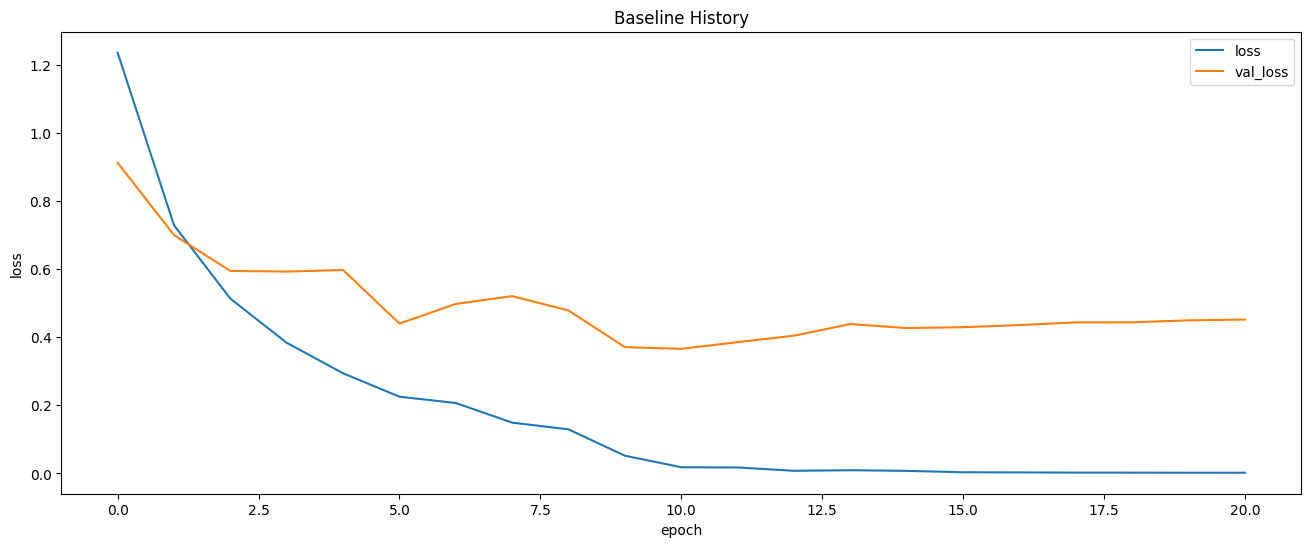

In [ ]:
metrics = baseline_history.history
plt.figure(figsize=(16, 6))
plt.plot(baseline_history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.title('Baseline History')
plt.show()

In [ ]:
baseline_test_results = baseline.evaluate(X_test_scaled, y_test, batch_size=64, return_dict=True)
baseline_test_results

31/31 [==============================] - 0s 4ms/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8999


{'loss': 0.44057679176330566, 'sparse_categorical_accuracy': 0.899898886680603}

In [ ]:
baseline.save('baseline.keras')

# Regularized

In [ ]:
regularized_history = regularized.fit(
    X_train_scaled, 
    y_train, 
    epochs=100,
    validation_data = (X_val_scaled, y_val),
    callbacks=callback
)

Epoch 1/100
219/219 [==============================] - 4s 13ms/step - loss: 1.8229 - sparse_categorical_accuracy: 0.4270 - val_loss: 1.2479 - val_sparse_categorical_accuracy: 0.5260 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 3s 12ms/step - loss: 1.2893 - sparse_categorical_accuracy: 0.5611 - val_loss: 0.9822 - val_sparse_categorical_accuracy: 0.6948 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 3s 13ms/step - loss: 1.0410 - sparse_categorical_accuracy: 0.6559 - val_loss: 0.8279 - val_sparse_categorical_accuracy: 0.7282 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 3s 12ms/step - loss: 0.8942 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7641 - val_sparse_categorical_accuracy: 0.7380 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 3s 16ms/step - loss: 0.7724 - sparse_categorical_accuracy: 0.7592 - val_loss: 0.6961 - val_sparse_categorical_accuracy: 0.7704 - lr: 0.0010
Epoch 6/100
219/219 [====

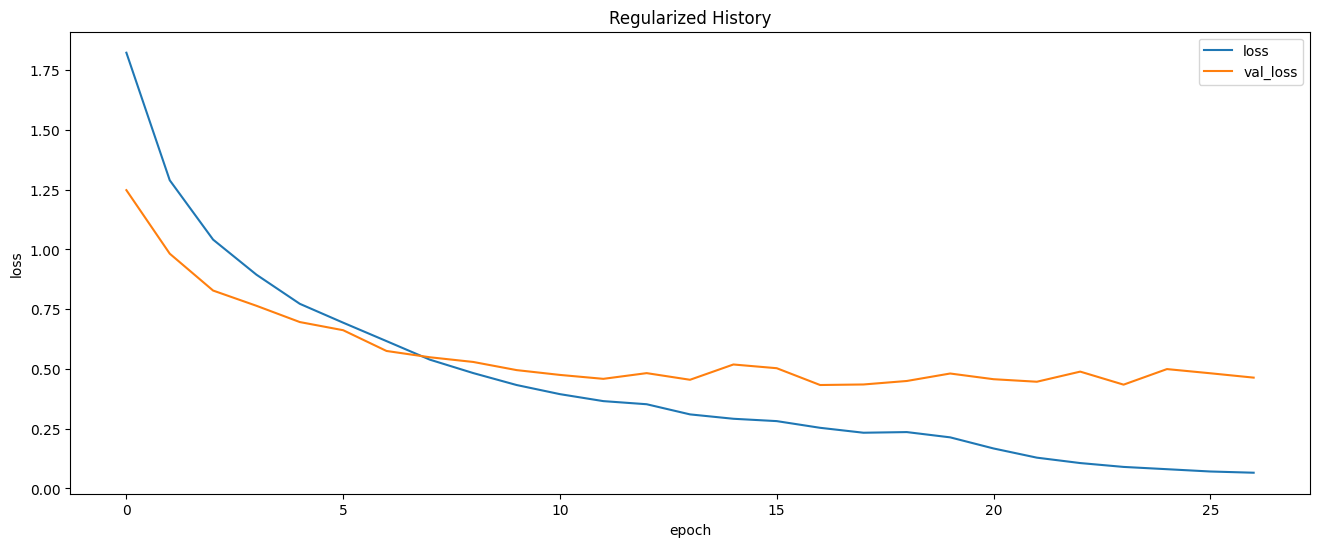

In [ ]:
metrics = regularized_history.history
plt.figure(figsize=(16, 6))
plt.plot(regularized_history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.title('Regularized History')
plt.show()

In [ ]:
regularized_test_results = regularized.evaluate(X_test_scaled, y_test, batch_size=64, return_dict=True)
regularized_test_results

31/31 [==============================] - 0s 5ms/step - loss: 0.4960 - sparse_categorical_accuracy: 0.8792


{'loss': 0.4959930181503296, 'sparse_categorical_accuracy': 0.8791708946228027}

In [ ]:
regularized.save('regularized.keras')

# Normalized

In [ ]:
normalized_history = normalized.fit(
    X_train_scaled, 
    y_train, 
    epochs=100,
    validation_data = (X_val_scaled, y_val),
    callbacks=callback
)

Epoch 1/100
219/219 [==============================] - 6s 17ms/step - loss: 1.7623 - sparse_categorical_accuracy: 0.4683 - val_loss: 1.2078 - val_sparse_categorical_accuracy: 0.6006 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 3s 14ms/step - loss: 1.2188 - sparse_categorical_accuracy: 0.5832 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.7242 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 3s 14ms/step - loss: 1.0166 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.7464 - val_sparse_categorical_accuracy: 0.7586 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 3s 16ms/step - loss: 0.9037 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6939 - val_sparse_categorical_accuracy: 0.7753 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 3s 14ms/step - loss: 0.8082 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.6233 - val_sparse_categorical_accuracy: 0.7870 - lr: 0.0010
Epoch 6/100
219/219 [====

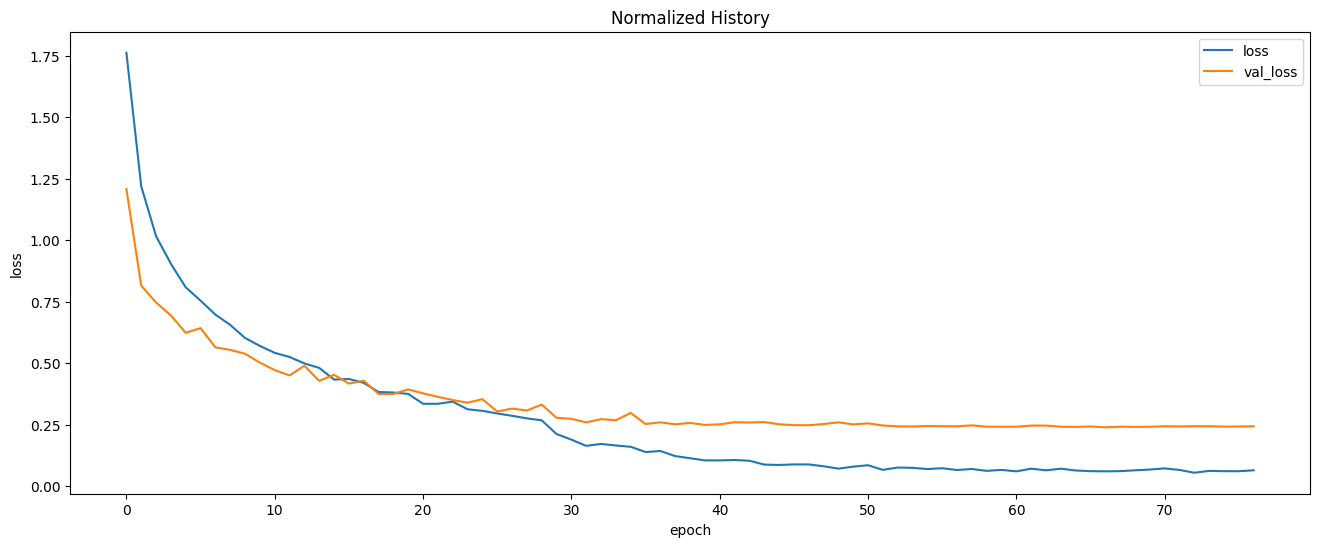

In [ ]:
metrics = normalized_history.history
plt.figure(figsize=(16, 6))
plt.plot(normalized_history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.title('Normalized History')
plt.show()

In [ ]:
normalized_test_results = normalized.evaluate(X_test_scaled, y_test, batch_size=64, return_dict=True)
normalized_test_results

31/31 [==============================] - 0s 5ms/step - loss: 0.3090 - sparse_categorical_accuracy: 0.9211


{'loss': 0.3090047538280487, 'sparse_categorical_accuracy': 0.9211324453353882}

In [ ]:
normalized.save('normalized.keras')

# In Depth Results

## Baseline

In [ ]:
y_pred = np.argmax(baseline.predict(X_test_scaled), axis=-1)
print(classification_report(y_test, y_pred))

62/62 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       198
           1       0.92      0.95      0.93       197
           2       0.86      0.87      0.87       198
           3       0.88      0.90      0.89       198
           4       0.90      0.93      0.91       197
           5       0.89      0.89      0.89       198
           6       0.94      0.95      0.94       198
           7       0.93      0.84      0.88       198
           8       0.91      0.90      0.90       198
           9       0.88      0.86      0.87       198

    accuracy                           0.90      1978
   macro avg       0.90      0.90      0.90      1978
weighted avg       0.90      0.90      0.90      1978



## Regularized

In [ ]:
y_pred = np.argmax(regularized.predict(X_test_scaled), axis=-1)
print(classification_report(y_test, y_pred))

62/62 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       198
           1       0.89      0.97      0.93       197
           2       0.77      0.87      0.82       198
           3       0.85      0.88      0.87       198
           4       0.90      0.82      0.86       197
           5       0.90      0.92      0.91       198
           6       0.93      0.91      0.92       198
           7       0.93      0.85      0.89       198
           8       0.87      0.87      0.87       198
           9       0.84      0.82      0.83       198

    accuracy                           0.88      1978
   macro avg       0.88      0.88      0.88      1978
weighted avg       0.88      0.88      0.88      1978



# Normalized

In [ ]:
y_pred = np.argmax(normalized.predict(X_test_scaled), axis=-1)
print(classification_report(y_test, y_pred))

62/62 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       198
           1       0.93      0.96      0.95       197
           2       0.85      0.91      0.88       198
           3       0.92      0.91      0.92       198
           4       0.93      0.94      0.93       197
           5       0.89      0.93      0.91       198
           6       0.95      0.96      0.96       198
           7       0.93      0.92      0.93       198
           8       0.92      0.91      0.92       198
           9       0.93      0.84      0.88       198

    accuracy                           0.92      1978
   macro avg       0.92      0.92      0.92      1978
weighted avg       0.92      0.92      0.92      1978

